# PIP examples

In this notebook we will show how to compute correlation functions with PIP and angular upweights.
Look first at notebook basic_examples.ipynb.

In [1]:
import os
import tempfile
import numpy as np
from scipy import spatial
from matplotlib import pyplot as plt

from pycorr import TwoPointCorrelationFunction, LandySzalayTwoPointEstimator,\
                   project_to_multipoles, setup_logging
from pycorr import utils

# To activate logging
setup_logging()

In [2]:
def generate_catalogs(size=50000, boxsize=(500,)*3, offset=(1000.,)*3, n_individual_weights=1, seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(-0.5, 0.5, size)*b for o, b in zip(offset, boxsize)]
    weights = [rng.uniform(0.5, 1., size) for i in range(n_individual_weights)]
    return positions, weights

In [3]:
# First, generate fake data with cartesian positions and weights
parent_positions, parent_weights = generate_catalogs()
randoms_positions, randoms_weights = generate_catalogs(size=100000, seed=84)

In [4]:
def find_close_pairs(positions, radius_in_degree=0.05):
    distance = sum(p**2 for p in positions)**0.5
    unit_positions = np.array([p/distance for p in positions]).T
    tree = spatial.cKDTree(unit_positions, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    radius = 2.*np.sin(np.radians(radius_in_degree) / 2.)
    pairs = tree.query_ball_tree(tree, radius, p=2., eps=0)
    toret = []
    for ii,indices in enumerate(pairs):
        if len(indices) > 1: toret.append(ii)
    return np.array(toret)

close_pairs_indices = find_close_pairs(parent_positions)
print('Found {:d}/{:d} close-pairs.'.format(len(close_pairs_indices),len(parent_positions[0])))

Found 33330/50000 close-pairs.


In [5]:
def run_fiber_assignment(size, nrealizations=64, prob=0.5, seed=42):
    toret = []
    rng = np.random.RandomState(seed=seed)
    for ireal in range(nrealizations):
        toret.append(rng.uniform(0., 1., size) < prob)
    return toret

# Getting fiber assignment runs
nrealizations = 65
bits_in_close_pairs = run_fiber_assignment(len(close_pairs_indices), nrealizations=nrealizations)
bits_in_parent = []
for bits in bits_in_close_pairs:
    mask = np.ones(len(parent_positions[0]), dtype='?')
    mask[close_pairs_indices] = bits
    bits_in_parent.append(mask)

this = bits_in_parent[0]
integerbits = utils.pack_bitarrays(*bits_in_parent[1:], dtype=np.uint64)
# Restricting to the objects that received a fiber
positions = [p[this] for p in parent_positions]
weights = [w[this] for w in parent_weights]
bitwise_weights = [w[this] for w in integerbits]

## Let's see the effect of fibre collisions on the clustering

[000000.34]  10-13 03:53  TwoPointCorrelationFunction  INFO     Using estimator NaturalTwoPointEstimator.
[000000.36]  10-13 03:53  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000005.66]  10-13 03:53  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000019.13]  10-13 03:53  TwoPointCorrelationFunction  INFO     Using estimator NaturalTwoPointEstimator.
[000019.13]  10-13 03:53  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000020.15]  10-13 03:53  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.


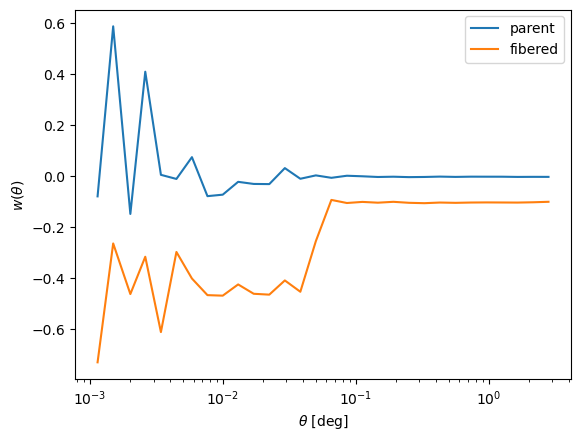

In [6]:
edges = np.logspace(-3, 0.5, 31)

parent_result = TwoPointCorrelationFunction('theta', edges, data_positions1=parent_positions, data_weights1=parent_weights,
                                            randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                            estimator='natural', engine='corrfunc', position_type='xyz', nthreads=4)

result = TwoPointCorrelationFunction('theta', edges, data_positions1=positions, data_weights1=weights,
                                     randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                     estimator='natural', engine='corrfunc', position_type='xyz', nthreads=4)
ax = plt.gca()
ax.plot(parent_result.sep, parent_result.corr, label='parent')
ax.plot(result.sep, result.corr, label='fibered')
ax.set_xscale('log')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$w(\theta)$')
ax.legend()
plt.show()

## PIP weights

[000031.27]  10-13 03:53  TwoPointCorrelationFunction  INFO     Using estimator NaturalTwoPointEstimator.
[000031.27]  10-13 03:53  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000032.27]  10-13 03:53  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000042.05]  10-13 03:54  TwoPointCorrelationFunction  INFO     Using estimator NaturalTwoPointEstimator.
[000042.05]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000043.25]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.


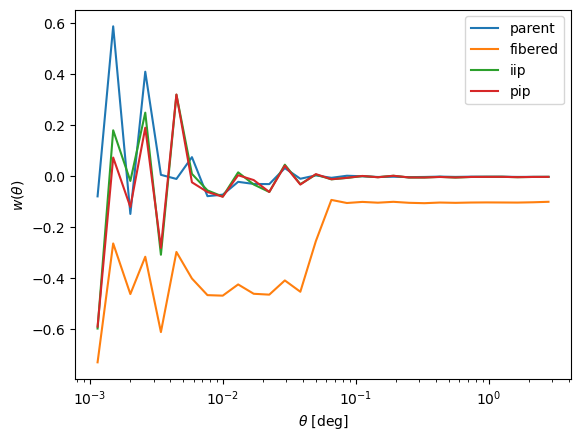

In [7]:
# First try with IIP weights
wiip = nrealizations/(1 + utils.popcount(*bitwise_weights))
iip_result = TwoPointCorrelationFunction('theta', edges, data_positions1=positions, data_weights1=wiip*weights[0],
                                     randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                     estimator='natural', engine='corrfunc', position_type='xyz', nthreads=4)
# Then PIP
pip_result = TwoPointCorrelationFunction('theta', edges, data_positions1=positions, data_weights1=bitwise_weights + weights,
                                     randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                     estimator='natural', engine='corrfunc', position_type='xyz', nthreads=4)
ax = plt.gca()
ax.plot(parent_result.sep, parent_result.corr, label='parent')
ax.plot(result.sep, result.corr, label='fibered')
ax.plot(iip_result.sep, iip_result.corr, label='iip')
ax.plot(pip_result.sep, pip_result.corr, label='pip')
ax.set_xscale('log')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$w(\theta)$')
ax.legend()
plt.show()

# Here PIP and IIP have the same effects, as no correlations was introduced between fiber assignement to a galaxy
# and its neighbors

## Angular weights

In [8]:
# We find in the parent sample as randoms, and switch to "weight" estimator
# First D1D2_parent/D1D2_PIP angular weight
edges = np.logspace(-3, 0.5, 31)
wangD1D2 = TwoPointCorrelationFunction('theta', edges, data_positions1=positions, data_weights1=bitwise_weights + weights,
                                       randoms_positions1=parent_positions, randoms_weights1=parent_weights,
                                       estimator='weight', engine='corrfunc', position_type='xyz', nthreads=4)

# First D1R2_parent/D1R2_IIP angular weight
# Input bitwise weights are automatically turned into IIP
wangD1R2 = TwoPointCorrelationFunction('theta', edges, data_positions1=positions, data_weights1=bitwise_weights + weights,
                                       data_positions2=randoms_positions, data_weights2=randoms_weights,
                                       randoms_positions1=parent_positions, randoms_weights1=parent_weights,
                                       randoms_positions2=randoms_positions, randoms_weights2=randoms_weights,
                                       estimator='weight', engine='corrfunc', position_type='xyz', nthreads=4)

[000054.14]  10-13 03:54  TwoPointCorrelationFunction  INFO     Using estimator WeightTwoPointEstimator.
[000054.15]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000055.32]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000057.94]  10-13 03:54  TwoPointCorrelationFunction  INFO     Using estimator WeightTwoPointEstimator.
[000057.94]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000064.53]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.


In [9]:
edges = (np.linspace(1e-9, 50, 51), np.linspace(0, 1., 101))
# No correction
result = TwoPointCorrelationFunction('smu', edges, data_positions1=positions, data_weights1=weights,
                                     randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                     engine='corrfunc', nthreads=4)
# PIP weights
pip_result = TwoPointCorrelationFunction('smu', edges, data_positions1=positions, data_weights1=bitwise_weights + weights,
                                         randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                         engine='corrfunc', nthreads=4)
# PIP weights + angular upweights D1D2_twopoint_weights and D1R2_twopoint_weights
pipang_result = TwoPointCorrelationFunction('smu', edges, data_positions1=positions, data_weights1=bitwise_weights + weights,
                                            randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                            D1D2_twopoint_weights=wangD1D2, D1R2_twopoint_weights=wangD1R2,
                                            engine='corrfunc', nthreads=4)

[000075.06]  10-13 03:54  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000075.06]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000075.62]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000076.12]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000076.82]  10-13 03:54  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000076.82]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000077.37]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000077.89]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000078.56]  10-13 03:54  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000078.56]  10-13 03:54  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000079.11]  10-13 03:54  

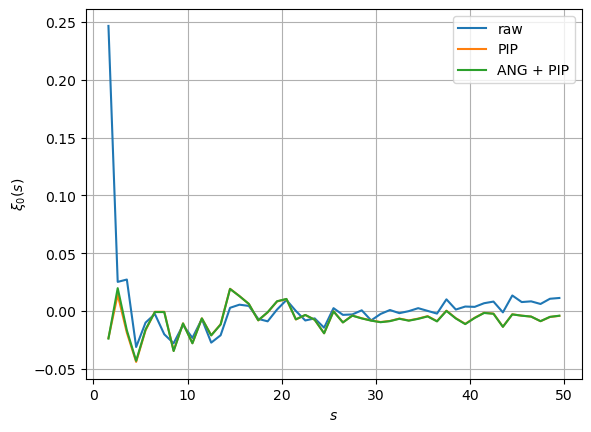

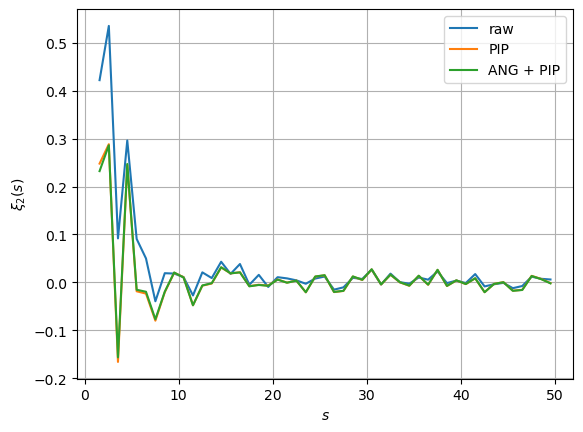

In [10]:
ells = (0, 2)
s, xiell = project_to_multipoles(result, ells=ells)
s, pip_xiell = project_to_multipoles(pip_result, ells=ells)
s, pipang_xiell = project_to_multipoles(pipang_result, ells=ells)

for ill,ell in enumerate(ells):
    ax = plt.gca()
    ax.plot(s, xiell[ill], label='raw', color='C0')
    ax.plot(s, pip_xiell[ill], label='PIP', color='C1')
    ax.plot(s, pipang_xiell[ill], label='ANG + PIP', color='C2')
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('$s$')
    ax.set_ylabel(r'$\xi_{:d}(s)$'.format(ell))
    plt.show()